#0. Pasos previos
## Importar librer√≠as

In [29]:
# 1. Importaci√≥n de librer√≠as
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#Importamos el modelo para espa√±ol porque sino todo explota
!python -m spacy download es_core_news_md
import spacy
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import LinearSVC #Segundo modelo de prueba
from sklearn.tree import DecisionTreeClassifier #Tercer modelo de prueba
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.3/42.3 MB 11.0 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1. Entendimiento y preparaci√≥n de los datos

## 1.1 Perfilamiento y an√°lisis de la calidad de los datos.

### Carga de datos

In [30]:
#Carga de los datos
data = pd.read_excel("Datos_proyecto.xlsx")  # Ajusta nombre si es diferente
print(data.head())

                                              textos  labels
0  "Aprendizaje" y "educaci√≥n" se consideran sin√≥...       4
1  Para los ni√±os m√°s peque√±os (beb√©s y ni√±os peq...       4
2  Adem√°s, la formaci√≥n de especialistas en medic...       3
3  En los pa√≠ses de la OCDE se tiende a pasar de ...       4
4  Este grupo se centr√≥ en las personas que padec...       3


In [31]:
# Ver informaci√≥n y tipado de data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


### An√°lisis de calidad de los datos

Para el an√°lisis de calidad de los datos, miraremos si hay valores nulos en alguno de los dos campos. Igualmente, nos interesa mirar si hay filas duplicadas. Un duplicado corresponder√≠a a dos textos iguales pero con labels distintos. Igualmente, buscamos detectar si hay textos muy cortos (menores a 10 caracteres).

In [32]:
# Valores nulos por columna
print("Valores nulos:\n", data.isnull().sum())

# Filas duplicadas
print("\nN√∫mero de filas duplicadas:", data.duplicated().sum())

# Vemos si un mismo texto tiene m√°s de un label asociado
duplicados_conflictivos = data.groupby("textos")["labels"].nunique()
conflictivos = duplicados_conflictivos[duplicados_conflictivos > 1]

print(f"N√∫mero de textos con m√°s de un label distinto: {len(conflictivos)}")
print("Ejemplos:\n", data[data["textos"].isin(conflictivos.index)].head(10))

# Valores √∫nicos de labels
print("\nLabels √∫nicos:", data["labels"].unique())
print("Distribuci√≥n de labels:\n", data["labels"].value_counts())

# Longitud de los textos
data["longitud_texto"] = data["textos"].astype(str).apply(len)

print("\nEstad√≠sticas de longitud de textos:")
print(data["longitud_texto"].describe())

# Detectar textos muy cortos
print("\nTextos con menos de 10 caracteres:")
print(data[data["longitud_texto"] < 10].head())


Valores nulos:
 textos    0
labels    0
dtype: int64

N√∫mero de filas duplicadas: 0
N√∫mero de textos con m√°s de un label distinto: 0
Ejemplos:
 Empty DataFrame
Columns: [textos, labels]
Index: []

Labels √∫nicos: [4 3 1]
Distribuci√≥n de labels:
 labels
4    1025
3     894
1     505
Name: count, dtype: int64

Estad√≠sticas de longitud de textos:
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud_texto, dtype: float64

Textos con menos de 10 caracteres:
Empty DataFrame
Columns: [textos, labels, longitud_texto]
Index: []


Vemos que no hay problemas relacionados a valores nulos en los datos, textos duplicados (0 y 0 respectivamente), o textos demasiado cortos (el texto m√°s corto tiene 303 caracteres, que puede corresponder a varias docenas de palabras). Con esto, decimos que no hay problemas significativos en la calidad de los datos.

Ahora, observaremos cu√°ntos registros hay por cada label (tipo de objetivo) en un gr√°fico de barras.

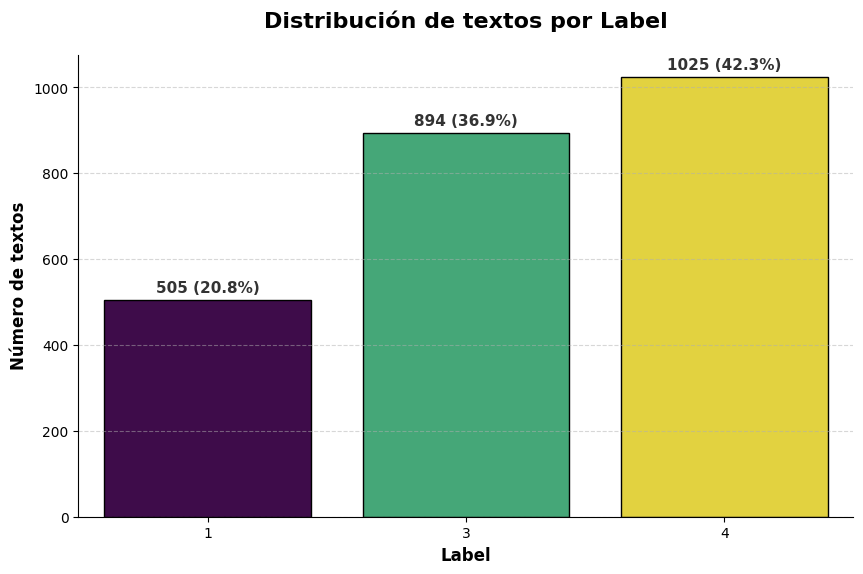

In [33]:
# Conteos
label_counts = data["labels"].value_counts().sort_index()
total = label_counts.sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    palette="viridis",
    edgecolor="black",
    legend = False
)

# A√±adir anotaciones en cada barra
for p, count in zip(ax.patches, label_counts.values):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2.,   # centro de la barra
        height + 10,                    # un poquito encima
        f"{count} ({count/total:.1%})", # valor + porcentaje
        ha="center", va="bottom",
        fontsize=11, fontweight="bold", color="#333"
    )

# T√≠tulo y estilo
plt.title("Distribuci√≥n de textos por Label", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Label", fontsize=12, fontweight="bold")
plt.ylabel("N√∫mero de textos", fontsize=12, fontweight="bold")
sns.despine()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Se observa que la moda para los datos es el label 4. El label 3 se acerca m√°s a 1/3 de los datos, que corresponder√≠a a una divisi√≥n totalmente equitativa entre los labels. Solo el 20% de los datos cuentan con el label 1. M√°s adelante se abordar√°n posibles opciones en busca de posiblemente prevenir sesgos que vienen de que un tipo de dato sea m√°s com√∫n que otro.

Veamos, a trav√©s de un histograma y un boxplot, c√≥mo se distribuye la longitud de los textos dados.

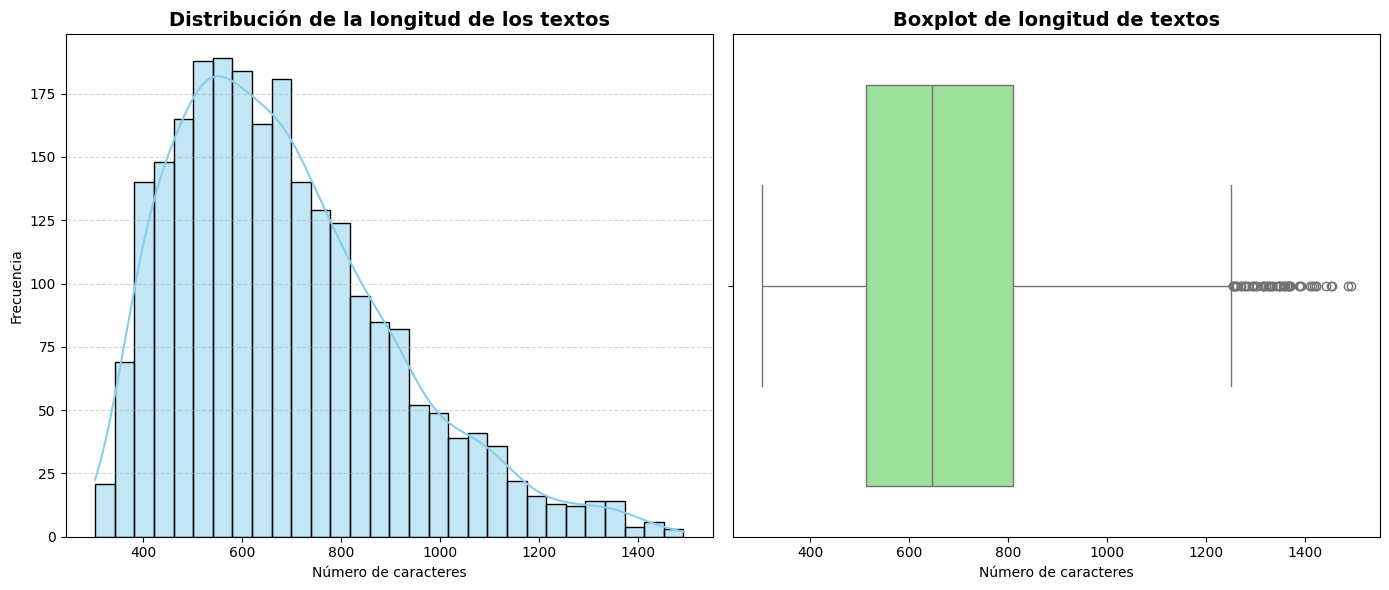

In [34]:
# Asegurarnos de tener la columna de longitud
data["longitud_texto"] = data["textos"].astype(str).apply(len)

plt.figure(figsize=(14,6))

# Histograma
plt.subplot(1,2,1)
sns.histplot(data["longitud_texto"], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Distribuci√≥n de la longitud de los textos", fontsize=14, fontweight="bold")
plt.xlabel("N√∫mero de caracteres")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=data["longitud_texto"], color="lightgreen")
plt.title("Boxplot de longitud de textos", fontsize=14, fontweight="bold")
plt.xlabel("N√∫mero de caracteres")

plt.tight_layout()
plt.show()

## 1.2 Tratamiento de los datos

Para preparar los datos se realiz√≥ un proceso de **preprocesamiento de texto en espa√±ol**. Inicialmente, aplicamos **lematizaci√≥n** con la librer√≠a spaCy, con el fin de reducir cada palabra a su forma base y eliminar variaciones morfol√≥gicas (por ejemplo, plurales o conjugaciones verbales). Esto permite un mejor agrupamiento sem√°ntico de los t√©rminos. Posteriormente, se utiliz√≥ la t√©cnica de **TF-IDF (Term Frequency - Inverse Document Frequency)** para representar cada texto como un vector num√©rico. Este m√©todo pondera las palabras seg√∫n su frecuencia en cada documento y su relevancia en todo el corpus, de manera que aquellas que aparecen en muchos textos comunes (como stopwords) pierden importancia, mientras que las m√°s representativas ganan peso en la matriz de caracter√≠sticas.


In [35]:
# Para lematizaci√≥n en espa√±ol
nlp = spacy.load("es_core_news_md")


#Preprocesamiento: lematizaci√≥n
def lemmatize_text(text):
    doc = nlp(str(text))
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop])

data["textos_proc"] = data["textos"].apply(lemmatize_text)

# 4. Vectorizaci√≥n TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["textos_proc"])
y = data["labels"]

#Las variables 'X' y 'Y' las usaremos m√°s adelante en el entrenamiento de los modelos
# PARA EL BONO EMBEDIDO
X_raw = data["textos"]   # Solo los string puros

Toca verificar cuantos datos hay en el entrenamiento de cada clase para que no haya m√©tricas sesgadas.

Ahora, ser√≠a interesante ver, por cada uno de los distintos objetivos de desarrollo sostenible (labels), cu√°les lemas ('palabras' resultantes despu√©s de hacer agrupaci√≥n por lematizaci√≥n) son los m√°s comunees.

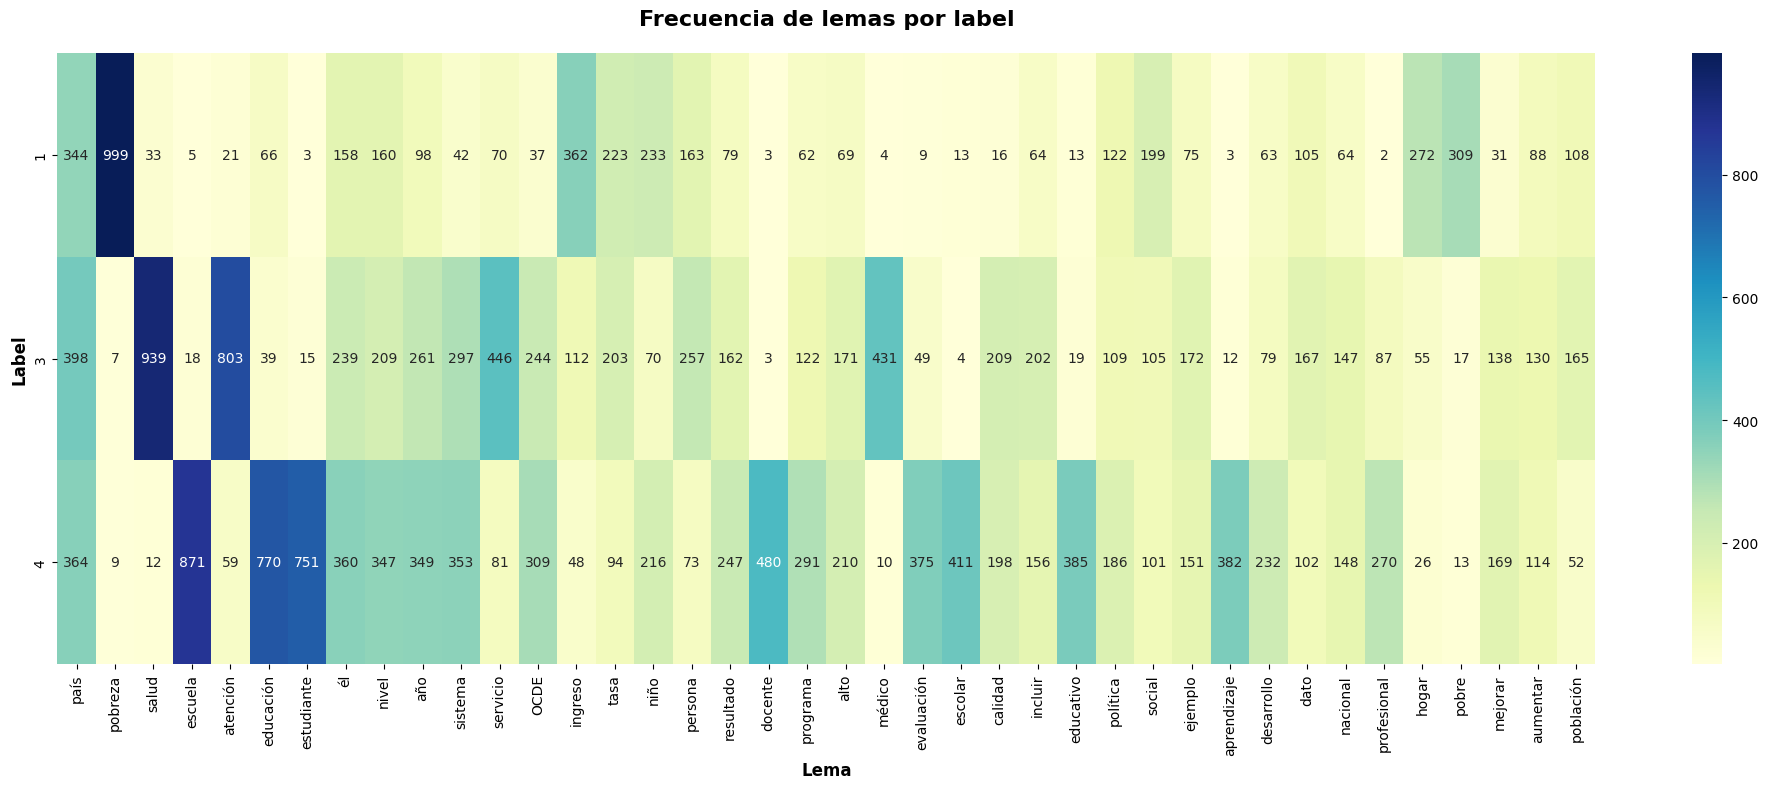

In [36]:
# Separar tokens por label
lemmatized_by_label = data.groupby("labels")["textos_proc"].apply(lambda x: " ".join(x)).reset_index()

# Contar frecuencias por label
freq_dicts = {}
for _, row in lemmatized_by_label.iterrows():
    label = row["labels"]
    tokens = row["textos_proc"].split()
    freq_dicts[label] = Counter(tokens)

# Unir en un DataFrame
freq_df = pd.DataFrame(freq_dicts).fillna(0).astype(int).T  # labels como filas
# Tomamos los N lemas m√°s frecuentes globalmente
N = 40
top_words = freq_df.sum(axis=0).sort_values(ascending=False).head(N).index
freq_df_top = freq_df[top_words]

# Dibujar heatmap
plt.figure(figsize=(20,8))
sns.heatmap(freq_df_top, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Frecuencia de lemas por label", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Lema", fontsize=12, fontweight="bold")
plt.ylabel("Label", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

El heatmap de frecuencias de lemas por objetivo permite identificar qu√© temas y vocabulario est√°n m√°s asociados a cada label. Por ejemplo, en el label 1 aparecen con fuerza t√©rminos vinculados a salud como ‚Äúsalud‚Äù y ‚Äúm√©dico‚Äù, lo que sugiere que este objetivo se relaciona principalmente con problem√°ticas sanitarias. En el label 3 destacan lemas como ‚Äúescuela‚Äù, ‚Äúestudiante‚Äù y ‚Äúprograma‚Äù, lo cual refleja una fuerte conexi√≥n con el √°mbito de la educaci√≥n. Por su parte, el label 4 muestra frecuencias altas en palabras como ‚Äúdocente‚Äù, ‚Äúevaluaci√≥n‚Äù y ‚Äúaprendizaje‚Äù, indicando un foco en calidad educativa y formaci√≥n profesional.

##1.3 Partici√≥n de los datos

Esta partici√≥n se realiza en tres set de datos, en la secci√≥n de "Selecci√≥n del modelo" se justificar√° la toma de esta decisi√≥n.

In [37]:
# Divisi√≥n en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #70% entrenamiento

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=1) # 0.3 x 1/3 = 10% para validaci√≥n


# 2. Modelado y Evaluaci√≥n

## 2.1 Modelos
Vamos a probar tres modelos con el fin de evaluar cu√°l es el mejor para nuestro negocio.

### 2.1.1 K-Vecinos (Juan David Torres Albarrac√≠n)

Una vez vectorizados los textos, se entren√≥ un **modelo de clasificaci√≥n supervisada basado en K-Nearest Neighbors (KNN)**. Para encontrar la mejor configuraci√≥n del clasificador, se implement√≥ un **GridSearchCV con validaci√≥n cruzada de 10 particiones**, explorando diferentes valores de hiperpar√°metros como el n√∫mero de vecinos (`n_neighbors`) y la m√©trica de distancia (`euclidean`, `manhattan`, `cosine`). El criterio de selecci√≥n fue el **F1-macro**, que eval√∫a de forma balanceada el desempe√±o en todas las clases, incluso cuando existe desbalance en las etiquetas. Finalmente, se evalu√≥ el modelo √≥ptimo en el conjunto de prueba, analizando m√©tricas como **exactitud, precisi√≥n, recall y F1-score**, as√≠ como la **matriz de confusi√≥n** para interpretar los resultados de la clasificaci√≥n.


Ahora, definimos los par√°metros que explorar√° cambiar el grid para encontrar un mejor modelo. En este caso se jugar√° con los tipos de distancia y el n√∫mero de vecinos.

In [38]:

# Definici√≥n del modelo KNN + GridSearch
param_grid = {
    "n_neighbors": list(range(1, 21)),
    "metric": ["euclidean", "manhattan", "cosine"]
}



Usamos una instancia de KFold para hacer validaci√≥n cruzada (cv) m√°s adelante. Se har√°n 10 particiones aleatorias de los datos.

In [39]:
cv = KFold(n_splits=10, shuffle=True, random_state=0)

Corremos el modelo el clasificador KNN usando el grid de par√°metros y mecanismo de verificaci√≥n cruzada definido anteriormente. En este caso, queremos un an√°lisis balanceado de los datos, por lo que el mejor modelo se escojer√° basado en su puntaje F1.

In [40]:
knn = KNeighborsClassifier()

# 1. Ajustamos el modelo con GridSearchCV
grid = GridSearchCV(knn, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)


Analizaremos gr√°ficamente los distintos puntajes obtenidos para cada forma de medir distancia con un n√∫mero K de vecinos m√°s cercanos (los par√°metros que variaron en el grid search).

Pivot (k x metric) ‚Äî primeras filas:
 metric    cosine  euclidean  manhattan
k                                     
1       0.916660   0.916660   0.419400
2       0.900408   0.900408   0.396660
3       0.937201   0.937201   0.426384
4       0.933012   0.933012   0.469135
5       0.948346   0.948346   0.577883
6       0.948577   0.948577   0.497794
7       0.952989   0.952989   0.521638
8       0.952257   0.952257   0.519036
9       0.961590   0.961590   0.518100
10      0.960874   0.960874   0.513738

Mejores hiperpar√°metros: {'metric': 'euclidean', 'n_neighbors': 13}
Nota: 'euclidean' y 'cosine' tienen valores id√©nticos. En el gr√°fico se har√° un breve desplazamiento para que se pueda ver


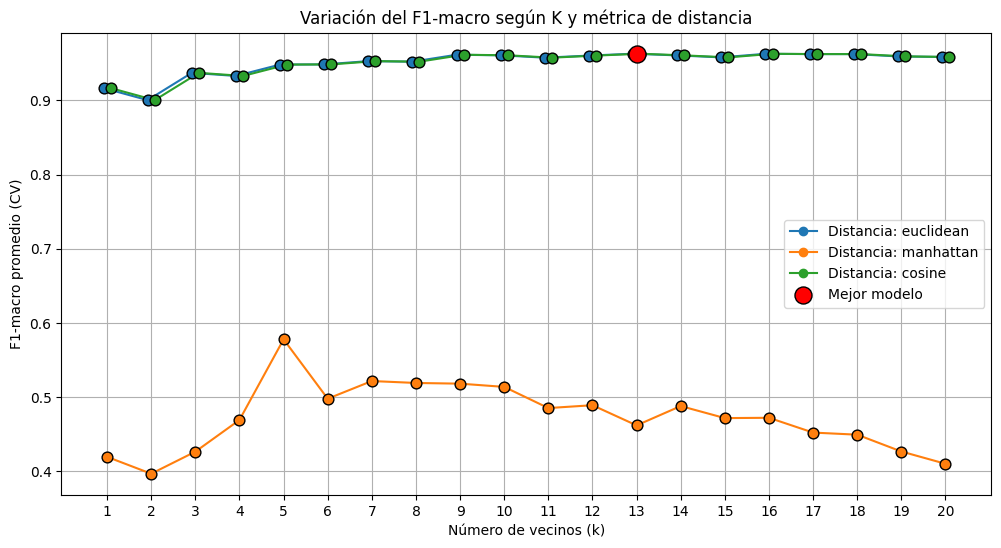

In [41]:

# ESTANDARIZAMOS nombres: si sklearn devuelve 'minkowski', usar param_p cuando exista,
# pero tambi√©n aceptar que param_metric ya puede venir como 'euclidean'/'manhattan'/'cosine'.
# B√ÅSICAMENTE CON ESTO NO EXPLOTA LA GR√ÅFICA POR LAS CONFUSIONES EN EL LABEL
def normalize_metric(row):
    m = str(row["param_metric"])
    # si existe 'param_p' en results, usarlo para distinguir minkowski
    if m == "minkowski" and "param_p" in results.columns:
        p = row.get("param_p", None)
        if p == 1:
            return "manhattan"
        elif p == 2:
            return "euclidean"
        else:
            return f"minkowski_p{p}"
    return m
results_graph = results.copy()
results_graph["metric_norm"] = results.apply(normalize_metric, axis=1)
# asegurarnos de que n_neighbors sea int (a veces es objeto)
results_graph["n_neighbors"] = results["param_n_neighbors"].astype(int)
results_summary = results_graph[["metric_norm", "n_neighbors", "mean_test_score"]].copy()
results_summary.columns = ["metric", "k", "mean_test"]

# Pivot: filas = k, columnas = metric, valores = mean_test
pivot = results_summary.pivot(index="k", columns="metric", values="mean_test")
pivot = pivot.sort_index()  # ordenar por k
print("Pivot (k x metric) ‚Äî primeras filas:\n", pivot.head(10))

# --- 2) identificamos el mejor modelo
best_params = grid.best_params_
print("\nMejores hiperpar√°metros:", best_params)
# normalizar nombre del mejor metric (en caso de 'minkowski' etc)
best_metric = ("euclidean" if best_params.get("metric") == "minkowski" else best_params.get("metric"))
best_k = int(best_params.get("n_neighbors"))
# obtenemos el best_score
try:
    best_score = float(pivot.loc[best_k, best_metric])
except Exception:
    # fallback
    best_score = float(results_summary[(results_summary["metric"]==best_metric)&(results_summary["k"]==best_k)]["mean_test"].iloc[0])

# comprobar solapamiento euclidean vs cosine (como los datos est√°n estandarizados, pueden ser muy similares)
if "euclidean" in pivot.columns and "cosine" in pivot.columns:
    same = np.allclose(pivot["euclidean"].fillna(np.nan), pivot["cosine"].fillna(np.nan), equal_nan=True)
    if same:
        print("Nota: 'euclidean' y 'cosine' tienen valores id√©nticos. En el gr√°fico se har√° un breve desplazamiento para que se pueda ver")

#  plotting (con ligero desplazamiento para ver puntos superpuestos).

plt.figure(figsize=(12,6))

metrics = [m for m in ["euclidean","manhattan","cosine"] if m in pivot.columns]
colors = {"euclidean":"tab:blue","manhattan":"tab:orange","cosine":"tab:green"}

for i, metric in enumerate(metrics):
    y_graph = pivot[metric].values
    x_graph = pivot.index.values.astype(float)
    jitter = (i - (len(metrics)-1)/2) * 0.08  # peque√±o desplazamiento horizontal
    xj = x_graph + jitter
    plt.plot(xj, y_graph, marker="o", label=f"Distancia: {metric}", color=colors.get(metric))
    plt.scatter(xj, y_graph, s=60, color=colors.get(metric), edgecolor="k", zorder=4)

# marcar mejor modelo
plt.scatter([best_k], [best_score], color="red", s=150, label="Mejor modelo", zorder=6, edgecolor="k")
plt.xticks(pivot.index)
plt.xlabel("N√∫mero de vecinos (k)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variaci√≥n del F1-macro seg√∫n K y m√©trica de distancia")
plt.grid(True)
plt.legend()
plt.show()


El programa nos muestra a este como el mejor modelo:
```
Mejores hiperpar√°metros: {'metric': 'euclidean', 'n_neighbors': 17}
```

Podemos ver que las distancias euclideanas y coseno tuvieron resultados muy parecidos, mientras la Manhattan tuvo resultados considerablemente peores. Para la distancia euclideana (marcada como la mejor por los datos obtenidos) se obtuvo el mejor puntaje F1-macro con 17 vecinos. Sin embargo, pareciera ser bastante constante el puntaje F1 en el rango de 13-20.

Ahora veremos la matriz de confusi√≥n del mejor modelo escogido.


--- Desempe√±o del mejor modelo ---
F1-macro (Entrenamiento): 0.9749
F1-macro (Test): 0.9574
F2-score Train: 0.9743994930821462
F2-score Test: 0.9580904603906392

Reporte de clasificaci√≥n (Test):
              precision    recall  f1-score   support

           1       0.93      0.95      0.94       149
           3       0.97      0.96      0.96       267
           4       0.97      0.97      0.97       312

    accuracy                           0.96       728
   macro avg       0.96      0.96      0.96       728
weighted avg       0.96      0.96      0.96       728



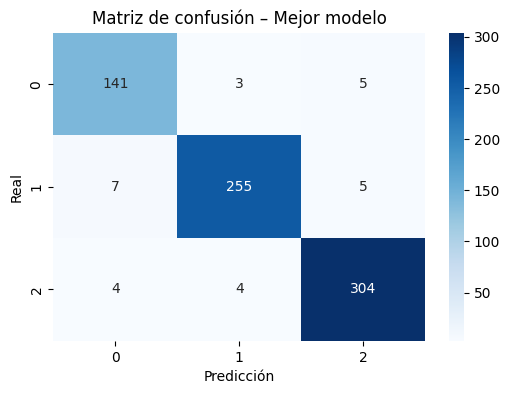

In [42]:

# evaluaci√≥n final del mejor modelo (train / test)
best_knn = grid.best_estimator_

y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)
train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempe√±o del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
f2 = fbeta_score(y_train, y_pred_train, beta=2, average='macro')
print("F2-score Train:", f2)
f22 = fbeta_score(y_test, y_pred_test, beta=2, average='macro')
print("F2-score Test:", f22)
print("\nReporte de clasificaci√≥n (Test):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo")
plt.show()

Para todos los labels, se tienen altos niveles de precisi√≥n y recall (>90%). No obstante, para el label 1, se tiene un nivel de precisi√≥n menor comparado al 3 y 4. Esta ordinalidad coincide con el n√∫mero de registros reportados en el an√°lisis de datos. Es decir, los labels con m√°s datos tienen, a su vez, mejores m√©tricas.

Con el fin de corregir alg√∫n posible sesgo, se aplicar√° el m√©todo SMOTE y se comparar√°n los resultados obtenidos. El c√≥digo con SMOTE es el siguiente:

In [43]:
print("Distribuci√≥n original de y_train:\n", y_train.value_counts())

# ------------------------------
# Definir pipeline con SMOTE + KNN
# ------------------------------
pipeline = Pipeline([
    ("smote", SMOTE(random_state=0, k_neighbors=5)),
    ("knn", KNeighborsClassifier())
])

# ------------------------------
# Hiperpar√°metros a buscar
# ------------------------------
param_grid = {
    "knn__n_neighbors": list(range(1, 21)),
    "knn__metric": ["euclidean", "manhattan", "cosine"]
}

cv = KFold(n_splits=10, shuffle=True, random_state=0)

# ------------------------------
# GridSearchCV
# ------------------------------
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)  # OJO: aqu√≠ SMOTE se aplica internamente solo en train


Distribuci√≥n original de y_train:
 labels
4    472
3    421
1    237
Name: count, dtype: int64


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'cosine'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             return_train_score=True, scoring='f1_macro')

Ahora, armamos nuevamente un gr√°fico analizando las m√©tricas para cada hiperpar√°metro.

Pivot (k x metric) ‚Äî primeras filas:
 metric    cosine  euclidean  manhattan
k                                     
1       0.912249   0.576375   0.419400
2       0.895133   0.440562   0.396660
3       0.922053   0.491537   0.427774
4       0.912833   0.435083   0.474565
5       0.924803   0.455473   0.585744

Mejores hiperpar√°metros: {'knn__metric': 'cosine', 'knn__n_neighbors': 19}


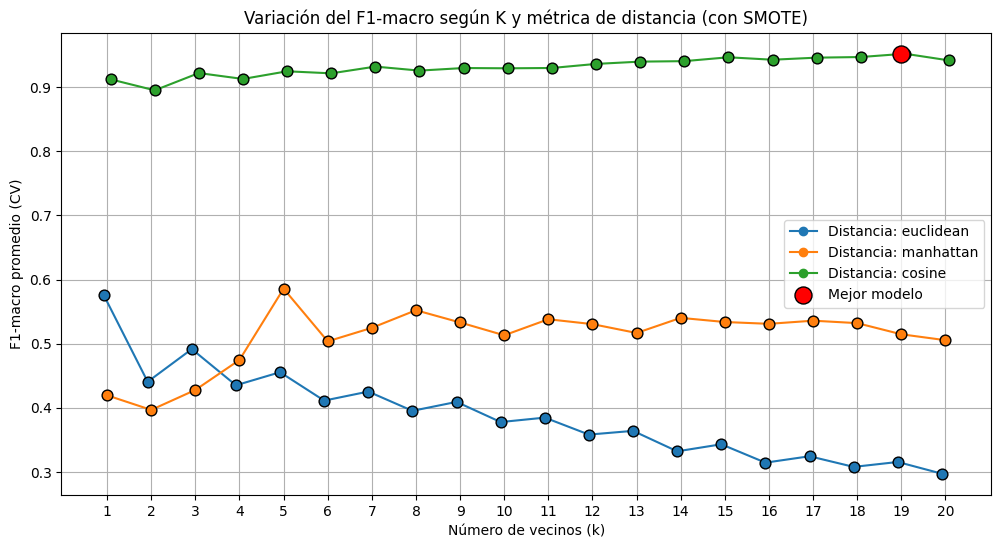

In [44]:
# ------------------------------
# Resultados
# ------------------------------
results = pd.DataFrame(grid.cv_results_)

# Normalizar nombres de m√©tricas
def normalize_metric(row):
    m = str(row["param_knn__metric"])
    if m == "minkowski" and "param_knn__p" in results.columns:
        p = row.get("param_knn__p", None)
        if p == 1:
            return "manhattan"
        elif p == 2:
            return "euclidean"
        else:
            return f"minkowski_p{p}"
    return m

results["metric_norm"] = results.apply(normalize_metric, axis=1)
results["k"] = results["param_knn__n_neighbors"].astype(int)
results_summary = results[["metric_norm", "k", "mean_test_score"]].copy()
results_summary.columns = ["metric", "k", "mean_test"]

# Pivot para graficar
pivot = results_summary.pivot(index="k", columns="metric", values="mean_test")
pivot = pivot.sort_index()
print("Pivot (k x metric) ‚Äî primeras filas:\n", pivot.head())

# ------------------------------
# Mejor modelo
# ------------------------------
best_params = grid.best_params_
print("\nMejores hiperpar√°metros:", best_params)

best_metric = best_params["knn__metric"]
best_k = int(best_params["knn__n_neighbors"])
best_score = float(
    results_summary[
        (results_summary["metric"] == best_metric) & (results_summary["k"] == best_k)
    ]["mean_test"].iloc[0]
)

# ------------------------------
# Gr√°fico comparativo
# ------------------------------
plt.figure(figsize=(12,6))
metrics = [m for m in ["euclidean","manhattan","cosine"] if m in pivot.columns]
colors = {"euclidean":"tab:blue","manhattan":"tab:orange","cosine":"tab:green"}

for i, metric in enumerate(metrics):
    y_vals = pivot[metric].values
    x_vals = pivot.index.values.astype(float)
    jitter = (i - (len(metrics)-1)/2) * 0.08
    xj = x_vals + jitter
    plt.plot(xj, y_vals, marker="o", label=f"Distancia: {metric}", color=colors.get(metric))
    plt.scatter(xj, y_vals, s=60, color=colors.get(metric), edgecolor="k", zorder=4)

# Resaltar mejor modelo
plt.scatter([best_k], [best_score], color="red", s=150, label="Mejor modelo", zorder=6, edgecolor="k")
plt.xticks(pivot.index)
plt.xlabel("N√∫mero de vecinos (k)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variaci√≥n del F1-macro seg√∫n K y m√©trica de distancia (con SMOTE)")
plt.grid(True)
plt.legend()
plt.show()


Esta vez, se obtuvo que este era el mejor modelo
```
Mejores hiperpar√°metros: {'knn__metric': 'cosine', 'knn__n_neighbors': 20}
```
Por otro lado, la distancia euclidiana empeor√≥ sus resultados considerablemente.

Ahora, observemos la matriz de confusi√≥n, y las m√©tricas para el modelo con mayor detalle.


--- Desempe√±o del mejor modelo (con SMOTE) ---
F1-macro (Entrenamiento): 0.9546
F1-macro (Test): 0.9395

Reporte de clasificaci√≥n (Test):
              precision    recall  f1-score   support

           1       0.84      0.99      0.91       149
           3       0.98      0.93      0.95       267
           4       0.98      0.94      0.96       312

    accuracy                           0.95       728
   macro avg       0.93      0.95      0.94       728
weighted avg       0.95      0.95      0.95       728



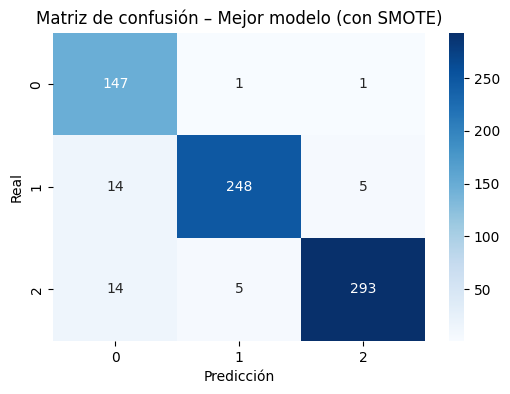

In [45]:
# ------------------------------
# Evaluaci√≥n final en test
# ------------------------------
best_knn = grid.best_estimator_

y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempe√±o del mejor modelo (con SMOTE) ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
print("\nReporte de clasificaci√≥n (Test):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo (con SMOTE)")
plt.show()

La aplicaci√≥n de la t√©cnica SMOTE buscaba mitigar el desbalance de clases presente en el conjunto de datos mediante la generaci√≥n de instancias sint√©ticas para las clases minoritarias. No obstante, los resultados muestran que el desempe√±o del modelo disminuy√≥ al incorporar este procedimiento, evidenciado en una reducci√≥n del puntaje F1-macro en el conjunto de prueba. Este fen√≥meno puede explicarse porque, si bien SMOTE equilibra la distribuci√≥n de clases en el entrenamiento, las instancias generadas no siempre reflejan patrones reales de los datos, lo que introduce ruido y posibles solapamientos entre clases. En consecuencia, el modelo tiende a sobreajustarse a ejemplos artificiales, reduciendo su capacidad de generalizaci√≥n frente a datos aut√©nticos.

En este contexto, los resultados sugieren que el desbalance de clases inicial no representaba un problema cr√≠tico para el desempe√±o del modelo. De hecho, el clasificador entrenado sin SMOTE alcanz√≥ un F1-macro superior en el conjunto de prueba, indicando una mejor capacidad de generalizaci√≥n y mayor equilibrio entre precisi√≥n y exhaustividad en la clasificaci√≥n real. Por lo tanto, se concluye que, para este caso particular, el modelo sin balanceo mediante SMOTE constituye la alternativa m√°s adecuada, mientras que el experimento con oversampling aporta un insumo valioso para comprender el impacto del desbalance y descartar la necesidad de su correcci√≥n en este escenario.

### 2.1.2 Support Vector Machine - Angie Guti√©rrez

En el tratamiento de datos los textos fueron transformados con TF-IDF, lo cual convierte las opiniones en puntos en un espacio enorme (cada palabra lematizada es una dimensi√≥n). Por lo tanto, se entren√≥ un **modelo de clasificaci√≥n supervisado basado en SVM** que tiene como objetivo buscar una frontera (una l√≠nea, plano o hiperplano) que separe lo mejor posible esos puntos en funci√≥n de la clase (En este caso ODS: 1, 3 o 4). Adem√°s, este intenta maximizar la distancia entre los puntos m√°s cercanos de cada clase y la frontera ‚Üí eso hace que generalice mejor en nuevos datos. Para este caso en particular, no se usa un SVM normal, si no un **LinearSVC que aplica un SVM lineal optimizado** para la clasificaci√≥n de texto y evita un SVM con kernel no lineal que es mucho m√°s lento (y es innecesario para este caso).

**Definici√≥n del modelo y par√°metros a explorar:**

Primero, vamos a jugar con el hiperpar√°metro **C** que controla la regularizaci√≥n, cuando se usan valores peque√±os el modelo es m√°s simple, pero cuando se utilizan valores grandes lo hacen m√°s flexible.

In [46]:
# Hiperpar√°metros a explorar
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

# Definimos la validaci√≥n cruzada
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Clasificador base
svm = LinearSVC(random_state=0, max_iter=5000)

**B√∫squeda de hiperpar√°metros con GridSearchCV**

Se usan 10 particiones de validaci√≥n cruzada y el criterio F1-macro para equilibrar el desempe√±o en todas las clases.

In [47]:
# GridSearch con validaci√≥n cruzada
grid = GridSearchCV(svm, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

# Resultados en DataFrame
results = pd.DataFrame(grid.cv_results_)

**An√°lisis gr√°fico de hiperpar√°metros**

Aqu√≠ vamos a observar c√≥mo cambia el desempe√±o seg√∫n el valor de C. Se eligi√≥ el que maximiza F1-macro que se puede evidenciar en el gr√°fico.

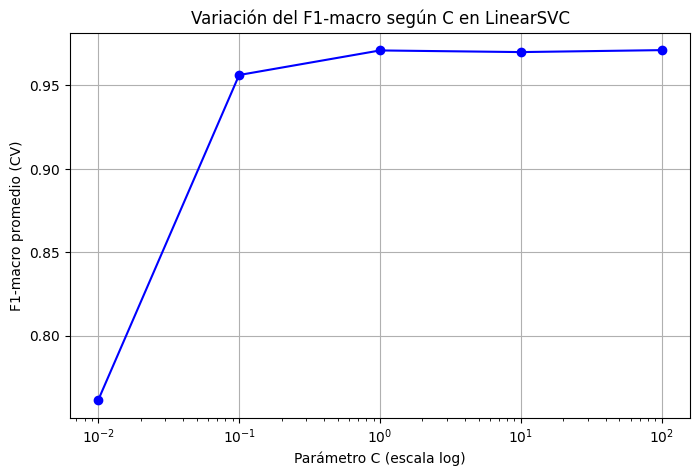

In [48]:
# Gr√°fica de F1-macro vs C
plt.figure(figsize=(8,5))
plt.plot(results["param_C"], results["mean_test_score"], marker="o", color="b")
plt.xscale("log")  # escala log para ver mejor C
plt.xlabel("Par√°metro C (escala log)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variaci√≥n del F1-macro seg√∫n C en LinearSVC")
plt.grid(True)
plt.show()

**Selecci√≥n del mejor modelo**

Se encontr√≥ que C=100 da el mejor resultado, balanceando precisi√≥n y recall. ‚≠ê

In [49]:
# Mejor modelo encontrado
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperpar√°metros:", best_params)
print("Mejor F1-macro (CV):", best_score)

Mejores hiperpar√°metros: {'C': 100}
Mejor F1-macro (CV): 0.9711657329010548


**Evaluaci√≥n en train y test**

Gracias a esta evaluaci√≥n, podemos evidenciar que el F1-macro es casi id√©ntico en entrenamiento (1.00) y prueba (0.9785), lo cual indica una buena generalizaci√≥n. üëè

In [50]:
# Evaluaci√≥n en train y test
best_svm = grid.best_estimator_
y_pred_train = best_svm.predict(X_train)
y_pred_test = best_svm.predict(X_test)

train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempe√±o del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")

# Mostrar reporte de clasificaci√≥n
print("\nReporte de clasificaci√≥n (Test):")
print(classification_report(y_test, y_pred_test))



--- Desempe√±o del mejor modelo ---
F1-macro (Entrenamiento): 1.0000
F1-macro (Test): 0.9622

Reporte de clasificaci√≥n (Test):
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       149
           3       0.97      0.96      0.96       267
           4       0.97      0.98      0.98       312

    accuracy                           0.97       728
   macro avg       0.96      0.96      0.96       728
weighted avg       0.97      0.97      0.97       728



**Matriz de confusi√≥n**

Gracias a la matriz podemos evidenciar los Falsos Positivos, Verdaderos Positivos, Falsos Negativos y Verdaderos Negativos.

Principalmente, notamos que hay unos pocos errores porque se confunde la ODS 1 (pobreza) con ODS 3 o 4.

Por otro lado, las clases ODS 3 y 4 se clasifican casi perfectas. üßë

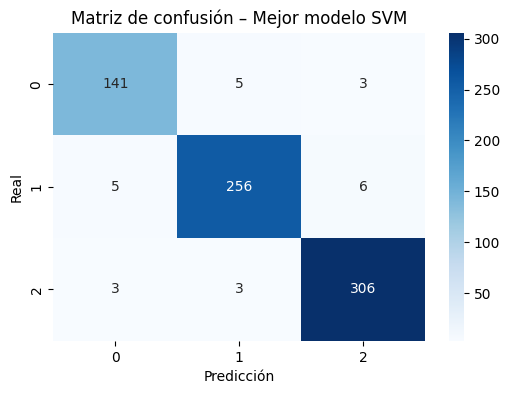

In [51]:
# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo SVM")
plt.show()

**Extracci√≥n de las palabras m√°s importantes que el SVM usa para decidir entre ODS**

Se muestran las 10 palabras m√°s relevantes que el modelo usa para distinguir cada ODS.

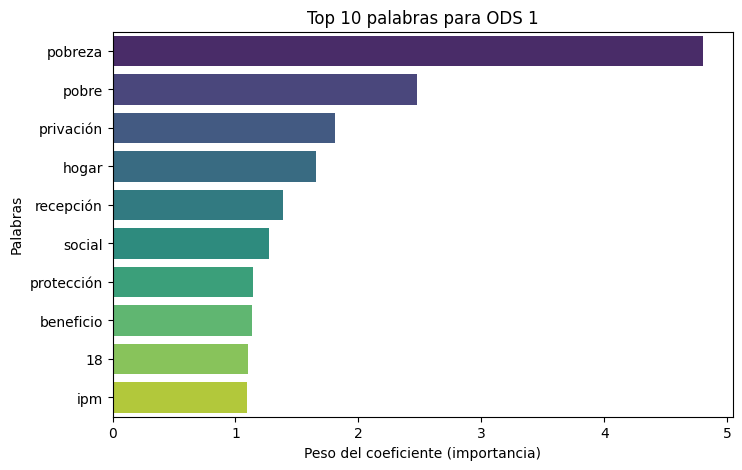

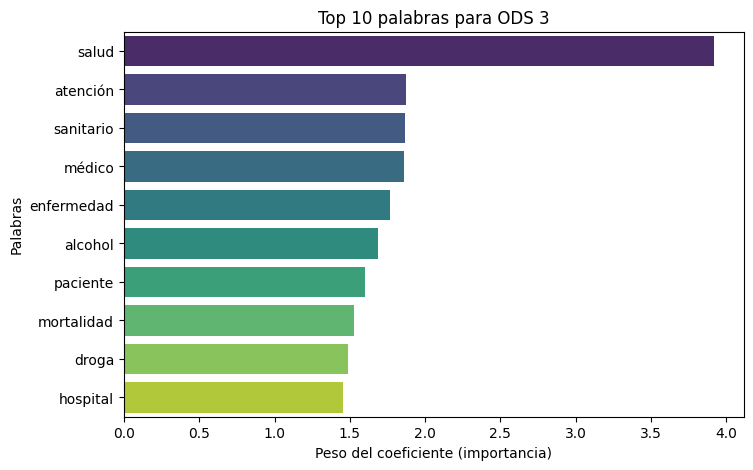

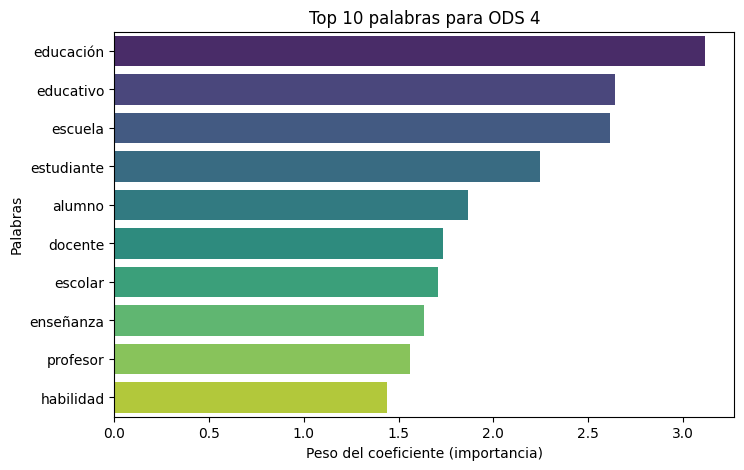

In [52]:
# Palabras del vectorizador
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = best_svm.coef_

def plot_top_words(coefs, feature_names, top_n=10):
    for i, class_label in enumerate(best_svm.classes_):
        top_indices = np.argsort(coefs[i])[-top_n:]
        top_features = [(feature_names[j], coefs[i][j]) for j in reversed(top_indices)]
        palabras, pesos = zip(*top_features)

        plt.figure(figsize=(8, 5))
        sns.barplot(x=pesos, y=palabras, hue=palabras, palette="viridis", dodge=False, legend=False)
        plt.title(f"Top {top_n} palabras para ODS {class_label}")
        plt.xlabel("Peso del coeficiente (importancia)")
        plt.ylabel("Palabras")
        plt.show()

plot_top_words(coefs, feature_names, top_n=10)

### Conclusiones del Support Vector Machine
* El desempe√±o por cada clase revela que en el ODS:

1. Pobreza: *precision=0.95, recall=0.95, f1=0.95*. Es decir, se pierden un peque√±o n√∫mero de casos por el recall pero es muy preciso.

3. Salud: *precision=0.97, recall=0.96, f1=0.96.* . Es decir, hay un gran equilibrio entre la precisi√≥n y la cobertura.

4. Educaci√≥n: *precision=0.97, recall=0.98, f1=0.98.* . Es decir, se reconocen pr√°cticamente todos los ejemplos gracias al recall.


* La matriz de confusi√≥n nos muestra que la mayor√≠a de los errores ocurren al confundir ODS 1 con ODS 3 o 4, estos falsos positivos pueden surgir debido a que algunos textos de pobreza incluyen menciones a salud o educaci√≥n. Por otro lado, ODS 3 y ODS 4 tienen casi clasificaci√≥n perfecta. :D

* El modelo con C=100 logra desempe√±o casi perfecto en entrenamiento (F1=1.0), lo que indica que ajusta fuertemente a los datos.

* En prueba, mantiene un alto rendimiento (F1=0.962), aunque ligeramente menor, lo que refleja un peque√±o grado de sobreajuste.


En t√©rminos generales, el clasificador SVM con C=100 es muy s√≥lido y confiable, alcanzando un accuracy global del 97%.

### 2.1.3 Arboles de Decision - Kalia Gonzalez

Mejores hiperpar√°metros: {'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mejor F1-macro (CV): 0.9306726915735293


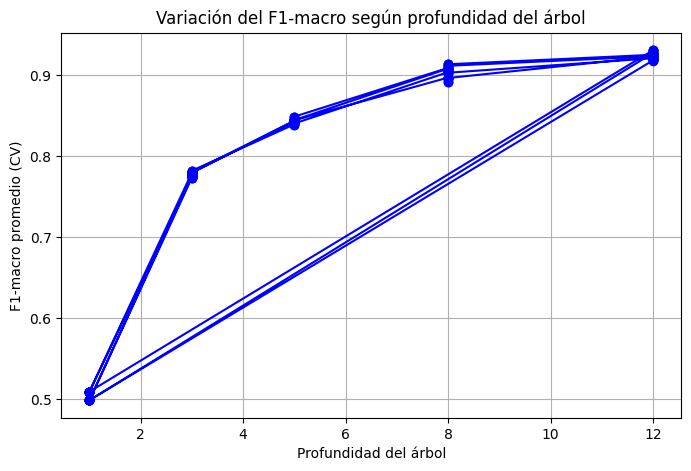

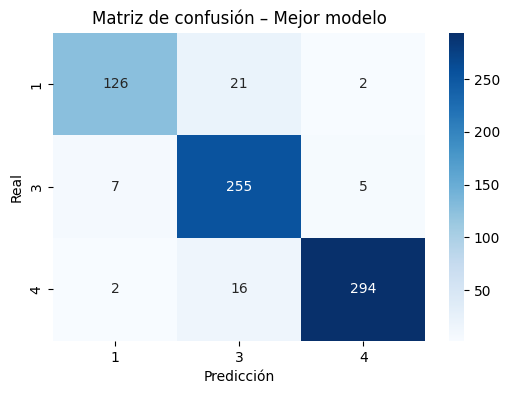


--- Desempe√±o del mejor modelo ---
F1-macro (Entrenamiento): 0.9470
F1-macro (Test): 0.9196
F2-score Train: 0.9451722411569721
F2-score Test: 0.9161108199191217

Reporte de clasificaci√≥n (Test):
              precision    recall  f1-score   support

           1       0.93      0.85      0.89       149
           3       0.87      0.96      0.91       267
           4       0.98      0.94      0.96       312

    accuracy                           0.93       728
   macro avg       0.93      0.91      0.92       728
weighted avg       0.93      0.93      0.93       728



In [53]:
#Hacemos diccionario con hiperparametros
param_grid = {'max_depth': [1, 3, 5, 8, 12],        # controla complejidad
    'min_samples_split': [2, 5, 10],         # evita sobreajuste
    'min_samples_leaf': [1, 2, 5],           # evita hojas muy peque√±as
    'class_weight': [None, 'balanced'],      # √∫til si hay desbalance
    'criterion': ['gini', 'entropy']}        #El criterio de pureza del arbol
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Mejores hiperpar√°metros:", grid.best_params_)
print("Mejor F1-macro (CV):", grid.best_score_)
best_dt = grid.best_estimator_
#Sacamos los resultados en un data frame
results = pd.DataFrame(grid.cv_results_)
#Graficamos el F1-score con respesto a los hiperparametros
plt.figure(figsize=(8,5))
plt.plot(results["param_max_depth"], results["mean_test_score"], marker="o", color="b")
plt.xlabel("Profundidad del √°rbol")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variaci√≥n del F1-macro seg√∫n profundidad del √°rbol")
plt.grid(True)
plt.show()
#Ahora mostramos la matriz de confusion
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo")
plt.show()
#Hacemos el clasification report
train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1  = f1_score(y_test,  y_pred_test,  average="macro")
print("\n--- Desempe√±o del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
f2 = fbeta_score(y_train, y_pred_train, beta=2, average='macro')
print("F2-score Train:", f2)
f22 = fbeta_score(y_test, y_pred_test, beta=2, average='macro')
print("F2-score Test:", f22)
print("\nReporte de clasificaci√≥n (Test):")
print(classification_report(y_test, y_pred_test))


##2.1.4 BONO - Word Embeddings con  SVM

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


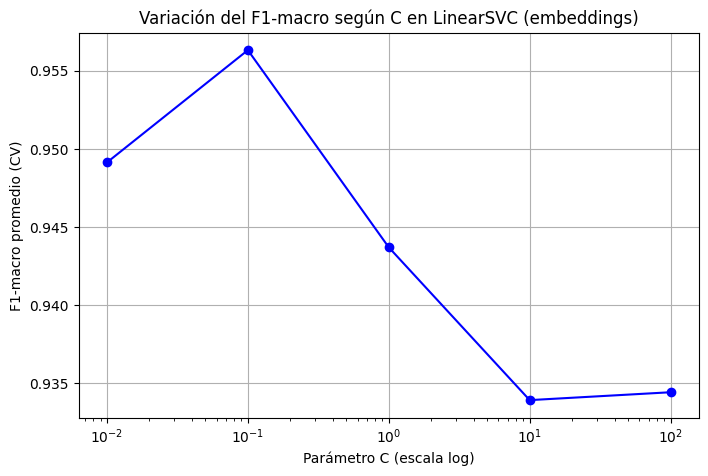

Mejores hiperpar√°metros: {'svm__C': 0.1}
Mejor F1-macro (CV): 0.9563182799311534

--- Desempe√±o del mejor modelo ---
F1-macro (Entrenamiento): 0.9857
F1-macro (Test): 0.9539

Reporte de clasificaci√≥n (Test):
              precision    recall  f1-score   support

           1       0.95      0.91      0.93       149
           3       0.96      0.96      0.96       267
           4       0.96      0.98      0.97       312

    accuracy                           0.96       728
   macro avg       0.96      0.95      0.95       728
weighted avg       0.96      0.96      0.96       728



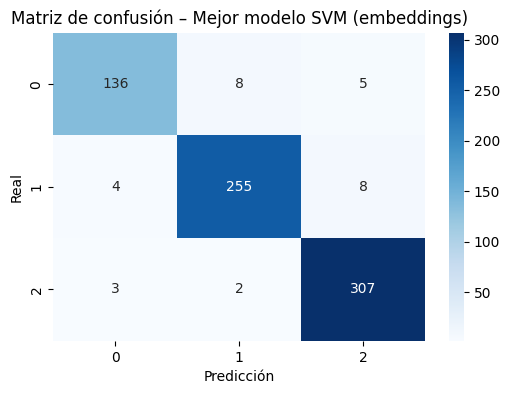

In [54]:
from sklearn.base import TransformerMixin

# partition on raw text
X_train_bono, X_test_bono, y_train_bono, y_test_bono = train_test_split(
    X_raw, y, test_size=0.3, random_state=0
)

#Transformer para embedding
class EmbeddingVectorizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectors = []
        for text in X:
            doc = nlp.make_doc(str(text))  # just tokenize, no parser/tagger
            # collect vectors for tokens that actually have embeddings
            word_vecs = [token.vector for token in doc if token.has_vector]
            if word_vecs:
                vectors.append(np.mean(word_vecs, axis=0))
            else:
                vectors.append(np.zeros(nlp.vocab.vectors_length))
        return np.array(vectors, dtype="float32")

# Definimos pipeline ---
svm = LinearSVC(random_state=0, max_iter=5000)
pipeline = Pipeline([
    ("embeddings", EmbeddingVectorizer()),
    ("svm", svm)
])

# Hiperpar√°metros a explorar ---
param_grid = {"svm__C": [0.01, 0.1, 1, 10, 100]}
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# GridSearch con validaci√≥n cruzada ---
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train_bono, y_train_bono)

# Resultados en DataFrame ---
results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8,5))
plt.plot(results["param_svm__C"], results["mean_test_score"], marker="o", color="b")
plt.xscale("log")
plt.xlabel("Par√°metro C (escala log)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variaci√≥n del F1-macro seg√∫n C en LinearSVC (embeddings)")
plt.grid(True)
plt.show()

# Mejor modelo encontrado ---
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperpar√°metros:", best_params)
print("Mejor F1-macro (CV):", best_score)

# Evaluaci√≥n en train y test ---
best_svm = grid.best_estimator_
y_pred_train = best_svm.predict(X_train_bono)
y_pred_test = best_svm.predict(X_test_bono)

train_f1 = f1_score(y_train_bono, y_pred_train, average="macro")
test_f1 = f1_score(y_test_bono, y_pred_test, average="macro")

print("\n--- Desempe√±o del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
print("\nReporte de clasificaci√≥n (Test):")
print(classification_report(y_test_bono, y_pred_test))

# Matriz de confusi√≥n ---
cm = confusion_matrix(y_test_bono, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo SVM (embeddings)")
plt.show()

Los resultados obtenidos muestran que el modelo SVM utilizando representaciones con word embeddings alcanz√≥ un desempe√±o muy s√≥lido. El mejor valor del hiperpar√°metro
ùê∂
C fue 0.1, con un F1-macro promedio en validaci√≥n cruzada de aproximadamente 0.956. Esto refleja que el modelo logra un buen equilibrio entre sesgo y varianza, evitando tanto el sobreajuste como el subajuste. Adem√°s, la curva de desempe√±o muestra que valores muy bajos o muy altos de
ùê∂
C reducen la capacidad del clasificador para generalizar adecuadamente, confirmando que el ajuste fino de este par√°metro es esencial para el rendimiento √≥ptimo.

En la evaluaci√≥n sobre los conjuntos de entrenamiento y prueba, se observa una alta consistencia: el F1-macro en entrenamiento fue de 0.9857 y en prueba de 0.9539. Esta cercan√≠a entre ambas m√©tricas indica que el modelo generaliza correctamente y no est√° sobreajustado a los datos de entrenamiento. El reporte de clasificaci√≥n confirma este hallazgo, con valores de precisi√≥n, recall y F1-score muy equilibrados entre las tres clases, alcanzando una exactitud global del 96%. La matriz de confusi√≥n refuerza esta conclusi√≥n, ya que la mayor√≠a de las instancias son clasificadas correctamente, con muy pocos errores de asignaci√≥n entre clases.



## 2.2 Selecci√≥n del modelo

Al analizar los resultados de los tres algoritmos, nos fijamos que el SVM obtuvo las mejores metricas . Con un recall entre el 95% y 98%, presicion entre 95% y 97% y el f1-score entre 95% y 98% lo que lo hace el modelo mas √≥ptimo :)


**Entrenamiento y Validaci√≥n**

Despu√©s de usar GridSearchCV, encontramos que el mejor hiperpar√°metro para el SVM fue:

{'C': 100}


Con este valor se entren√≥ el modelo en el conjunto de entrenamiento y luego se evalu√≥ con el conjunto de validaci√≥n (10% de los datos originales).

In [55]:
# 1. Entrenamiento con mejor hiperpar√°metro
best_svm = LinearSVC(random_state=0, max_iter=5000, C=100)
best_svm.fit(X_train, y_train)

LinearSVC(C=100, max_iter=5000, random_state=0)

**¬øPor qu√© era necesaria la partici√≥n?**

Recordemos que la partici√≥n de datos se realiz√≥ en tres set train -> test -> validation.

- Entrenamiento (Train):
En esta partici√≥n (70% de los datos), el modelo aprende los patrones de los textos y ajusta sus par√°metros internos. Aqu√≠ no evaluamos desempe√±o, porque el modelo ya "vio" estos datos y ser√≠a enga√±oso.

- Evaluaci√≥n inicial (Test ‚Äì 20% de los datos):
El conjunto de prueba es la evaluaci√≥n principal. Nos permite medir qu√© tan bien el modelo generaliza a datos que no fueron usados en el entrenamiento.
Adem√°s, con esta se calcula la matriz de confusi√≥n y m√©tricas como precisi√≥n, recall y F1 para CADA UNO DE LOS MODELOS. Realmente, es la m√©trica de referencia para comparar modelos.

- Validaci√≥n final (Validation ‚Äì 10% de los datos):
Este conjunto funciona como una segunda capa de verificaci√≥n.

En conclusi√≥n, el test nos da confianza en el modelo, la validaci√≥n nos permite contrastar estabilidad y robustez.
Si el modelo mantiene un desempe√±o similar en validation, significa que no est√° sobreajustado y tiene buena capacidad de generalizaci√≥n.

In [56]:
# 2. Evaluaci√≥n en VALIDATION
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
y_val_pred = best_svm.predict(X_val)

val_metrics = {
    "F1-macro": f1_score(y_val, y_val_pred, average="macro"),
    "Balanced Accuracy": balanced_accuracy_score(y_val, y_val_pred),
    "Cohen‚Äôs Kappa": cohen_kappa_score(y_val, y_val_pred)
}

val_report = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).T
display(pd.DataFrame([val_metrics]).T.rename(columns={0:"Validation"}).style.background_gradient(cmap="Blues"))
display(val_report.style.background_gradient(cmap="Greens"))

Gracias a las m√©tricas del set de validaci√≥n, notamos que el modelo mantiene un desempe√±o estable y muy alto, confirmando que no hubo sobreajuste respecto al conjunto de prueba.

El Cohen‚Äôs Kappa > 0.95 muestra una alt√≠sima concordancia entre las predicciones y las etiquetas reales, lo cual valida la robustez del clasificador.

El Balanced Accuracy ‚âà 0.97 indica que el modelo trata a todas las clases de manera equitativa, sin favorecer a la clase mayoritaria.

Las m√©tricas por clase muestran un rendimiento especialmente fuerte en ODS 4 (Educaci√≥n), con recall de 0.975, lo que significa que casi todos los textos de este ODS son correctamente detectados.

Las ligeras confusiones siguen d√°ndose en ODS 1 (Pobreza), donde el recall fue un poco m√°s bajo (0.958), lo cual tiene sentido dado el solapamiento sem√°ntico con otros ODS.

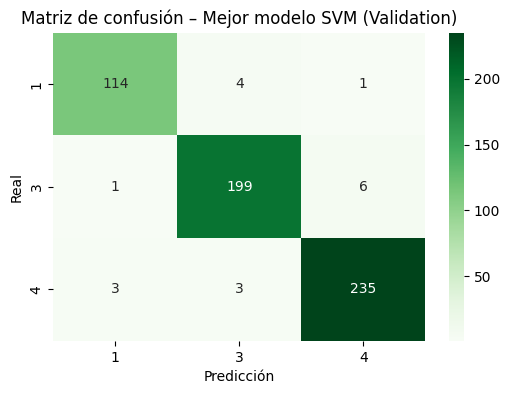

In [57]:
# 5. Matriz de confusi√≥n (  DE VALIDATION)
conf_mat_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_val, annot=True, fmt="d", cmap="Greens",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n ‚Äì Mejor modelo SVM (Validation)")
plt.show()

**Contraste con el test**

A continuaci√≥n, mostraremos las mismas m√©tricas aplicadas pero al set de test.

In [58]:
# 3. Evaluaci√≥n en TEST
y_test_pred = best_svm.predict(X_test)

test_metrics = {
    "F1-macro": f1_score(y_test, y_test_pred, average="macro"),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_test_pred),
    "Cohen‚Äôs Kappa": cohen_kappa_score(y_test, y_test_pred)
}

test_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
display(pd.DataFrame([test_metrics]).T.rename(columns={0:"Test"}).style.background_gradient(cmap="Blues"))
display(test_report.style.background_gradient(cmap="Greens"))

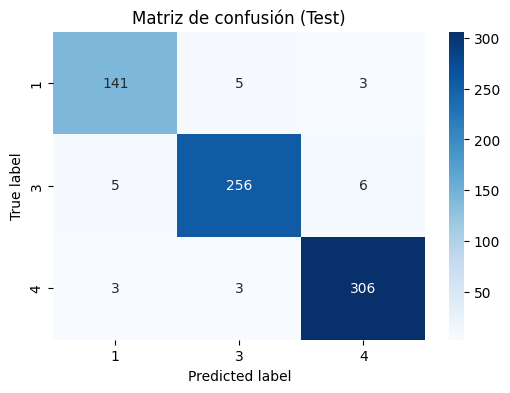

In [59]:
# 4. Matriz de confusi√≥n De TEST
conf_mat = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Matriz de confusi√≥n (Test)")
plt.show()

Se muestra que ambos conjuntos muestran resultados muy consistentes (diferencias menores a 0.01 en las m√©tricas), lo que confirma que el modelo no depende de una partici√≥n espec√≠fica de los datos.

En Test, el modelo alcanz√≥ un F1-macro de 0.962, con excelente desempe√±o en todas las clases.

En Validation, las m√©tricas incluso mejoraron ligeramente (F1-macro de 0.967), lo cual indica buena capacidad de generalizaci√≥n.

La m√©trica de Cohen‚Äôs Kappa > 0.94 en ambos casos demuestra una concordancia muy fuerte entre predicciones y etiquetas reales.

En las m√©tricas por clase:

ODS 1 (Pobreza): es la clase m√°s desafiante, con un recall de 0.946 en Test y 0.958 en Validaci√≥n.

ODS 3 (Salud) y ODS 4 (Educaci√≥n): muestran un desempe√±o balanceado y superior al 0.96 en F1.

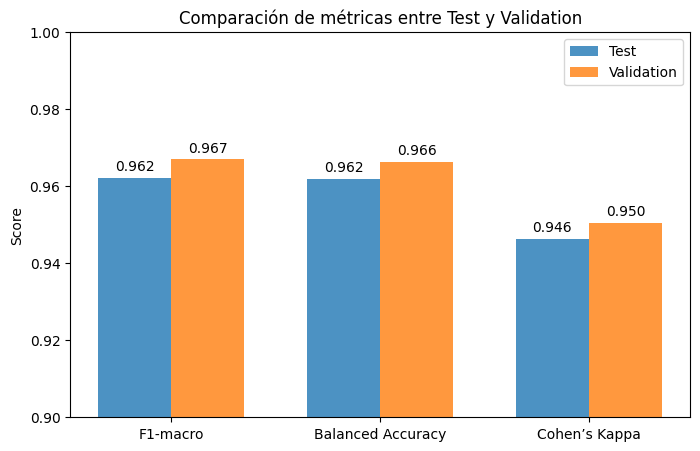

In [60]:
# M√©tricas de Test
test_scores = {
    "F1-macro": 0.962201,
    "Balanced Accuracy": 0.961960,
    "Cohen‚Äôs Kappa": 0.946315
}

# M√©tricas de Validation
val_scores = {
    "F1-macro": 0.967043,
    "Balanced Accuracy": 0.966369,
    "Cohen‚Äôs Kappa": 0.950437
}

# Preparar datos
metrics = list(test_scores.keys())
test_vals = list(test_scores.values())
val_vals = list(val_scores.values())
x = np.arange(len(metrics))
width = 0.35

# Graficar
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, test_vals, width, label="Test", alpha=0.8)
bars2 = ax.bar(x + width/2, val_vals, width, label="Validation", alpha=0.8)

# Etiquetas y estilo
ax.set_ylabel("Score")
ax.set_title("Comparaci√≥n de m√©tricas entre Test y Validation")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.9, 1.0)
ax.legend()

# Mostrar valores encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

## An√°lisis palabras clave

Adicionalmente, veremos el top de las palabras usadas para la clasificaci√≥n de cada clase para evidenciar si hay l√≥gica o tiene sentido.

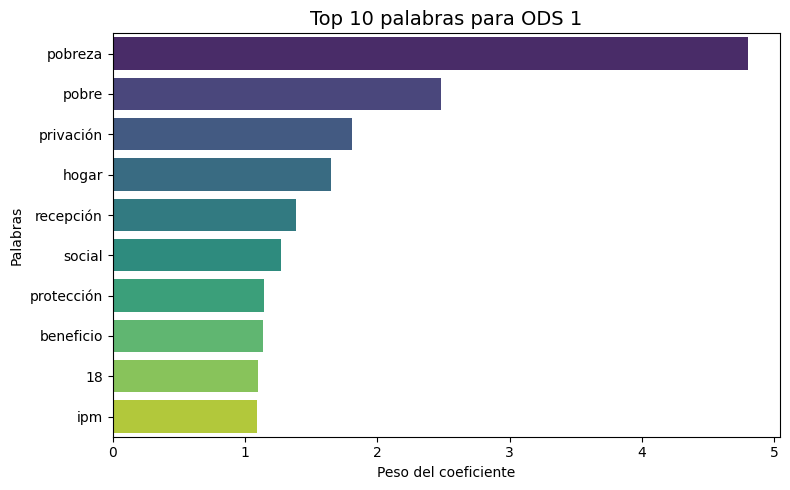

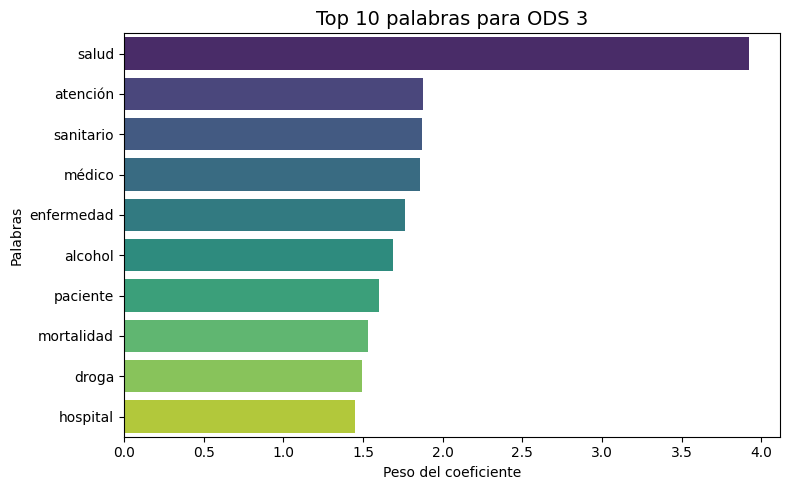

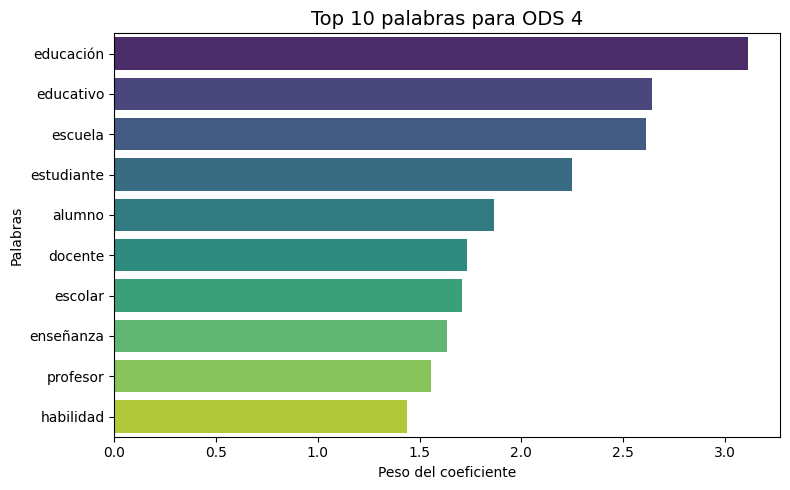

In [61]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = best_svm.coef_

def plot_top_words_separadas(coefs, feature_names, top_n=10):
    for i, class_label in enumerate(best_svm.classes_):
        top_indices = np.argsort(coefs[i])[-top_n:]
        top_features = [(feature_names[j], coefs[i][j]) for j in reversed(top_indices)]
        palabras, pesos = zip(*top_features)

        plt.figure(figsize=(8, 5))
        sns.barplot(
            x=pesos,
            y=palabras,
            hue=palabras,
            palette="viridis",
            dodge=False,
            legend=False
        )
        plt.title(f"Top {top_n} palabras para ODS {class_label}", fontsize=14)
        plt.xlabel("Peso del coeficiente")
        plt.ylabel("Palabras")
        plt.tight_layout()
        plt.show()

plot_top_words_separadas(coefs, feature_names, top_n=10)

El an√°lisis de las palabras m√°s representativas para cada ODS permite identificar de manera clara los temas y preocupaciones que la ciudadan√≠a asocia con cada objetivo. En el caso del ODS 1 (Fin de la pobreza), t√©rminos como pobreza, privaci√≥n, hogar o protecci√≥n evidencian que las opiniones se centran en las carencias b√°sicas y en la necesidad de pol√≠ticas de protecci√≥n social. Esto indica que la organizaci√≥n debe fortalecer sus estrategias de apoyo a hogares vulnerables y programas de transferencia de beneficios, lo cual responde directamente a las demandas identificadas en los textos analizados.

Para el ODS 3 (Salud y bienestar), la presencia de palabras como salud, atenci√≥n, m√©dico, enfermedad o hospital refleja la importancia que los ciudadanos atribuyen al acceso a servicios m√©dicos de calidad y a la atenci√≥n sanitaria en general. Esta informaci√≥n puede orientar a la organizaci√≥n a dise√±ar campa√±as enfocadas en la promoci√≥n de h√°bitos saludables, prevenci√≥n de enfermedades y mejora de la infraestructura hospitalaria. Asimismo, la menci√≥n de alcohol y droga sugiere la necesidad de pol√≠ticas p√∫blicas m√°s s√≥lidas en torno a la salud mental y las adicciones.

En cuanto al ODS 4 (Educaci√≥n de calidad), palabras como educaci√≥n, escuela, docente, profesor y estudiante ponen de relieve que la ciudadan√≠a relaciona este objetivo con la calidad del sistema educativo y la formaci√≥n de los actores que participan en √©l. De esta manera, la organizaci√≥n podr√≠a priorizar estrategias para mejorar las competencias de los docentes, garantizar el acceso equitativo a la educaci√≥n y fomentar habilidades que preparen a los estudiantes para los retos sociales y laborales.

En conjunto, estos resultados muestran que el an√°lisis de lenguaje natural no solo permite clasificar autom√°ticamente las opiniones en funci√≥n de los ODS, sino tambi√©n identificar con precisi√≥n los temas clave que deben ser abordados. Para la organizaci√≥n, esta informaci√≥n resulta valiosa porque facilita la toma de decisiones basadas en evidencia y permite dise√±ar pol√≠ticas y estrategias focalizadas que respondan directamente a las percepciones y necesidades expresadas por la poblaci√≥n.

## Conclusiones del mejor modelo (SVC)

- El SVM lineal con C=100 se consolid√≥ como el mejor modelo, alcanzando F1-macro ‚âà 0.96‚Äì0.97 en Test y Validation.

- La coherencia entre ambos conjuntos confirma que el modelo no est√° sobreajustado y es robusto para nuevos datos.

- El equilibrio entre precisi√≥n y recall lo hace adecuado para clasificaci√≥n autom√°tica de textos en los ODS 1, 3 y 4, minimizando falsos positivos y negativos de forma equitativa.

- Este contraste entre Test y Validation demuestra que el modelo no solo funciona bien en la fase de prueba, sino que tambi√©n mantiene su calidad predictiva en escenarios reales.

## 2.3 Dataset de test

In [62]:
# Entrenar en el conjunto de entrenamiento
best_model = LinearSVC(random_state=0, max_iter=5000, C=100)
best_model.fit(X_train, y_train)

# Evaluar en validaci√≥n
y_val_pred = best_model.predict(X_val)
print("F1-macro (Validaci√≥n):", f1_score(y_val, y_val_pred, average='macro'))
print("\nReporte de clasificaci√≥n (Validaci√≥n):")
print(classification_report(y_val, y_val_pred))

F1-macro (Validaci√≥n): 0.9670432066865963

Reporte de clasificaci√≥n (Validaci√≥n):
              precision    recall  f1-score   support

           1       0.97      0.96      0.96       119
           3       0.97      0.97      0.97       206
           4       0.97      0.98      0.97       241

    accuracy                           0.97       566
   macro avg       0.97      0.97      0.97       566
weighted avg       0.97      0.97      0.97       566



In [63]:
#Carga de datos para el de prueba
prueba = pd.read_excel("Datos de prueba_proyecto.xlsx")
print(prueba.head())

                                      Textos_espanol
0  El rector, que es el representante local del M...
1  Tenga en cuenta que todos los programas antipo...
2  Debido a que son en gran medida invisibles, es...
3  Los recursos a√∫n son limitados en este sector....
4  Durante el per√≠odo 1985-2008, la educaci√≥n pri...


In [64]:
prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  152 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


In [65]:
#Hacemos el analisis de calidad de los datos
# Valores nulos por columna
print("Valores nulos:\n", prueba.isnull().sum())

# Filas duplicadas
print("\nN√∫mero de filas duplicadas:", prueba.duplicated().sum())

# Longitud de los textos
prueba["longitud_texto"] = prueba["Textos_espanol"].astype(str).apply(len)

print("\nEstad√≠sticas de longitud de textos:")
print(prueba["longitud_texto"].describe())

# Detectar textos muy cortos
print("\nTextos con menos de 10 caracteres:")
print(prueba[prueba["longitud_texto"] < 10].head())

Valores nulos:
 Textos_espanol    0
dtype: int64

N√∫mero de filas duplicadas: 0

Estad√≠sticas de longitud de textos:
count     152.000000
mean      677.638158
std       218.683798
min       340.000000
25%       521.000000
50%       619.500000
75%       817.500000
max      1298.000000
Name: longitud_texto, dtype: float64

Textos con menos de 10 caracteres:
Empty DataFrame
Columns: [Textos_espanol, longitud_texto]
Index: []


In [66]:
#Se realiza un cambio en la funcion lemmatize_text ya que necesitamos una Funcion Transformadora para que
#pueda realzar el proceso de automatizacion
def lemmatize_batch(X):
    s = pd.Series(X).astype(str)
    out = []
    for doc in nlp.pipe(s.tolist(), batch_size=64, disable=["ner"]):
        out.append(" ".join([t.lemma_ for t in doc if not t.is_punct and not t.is_stop]))
    return np.array(out)
# Luego se aplica la vectoriacion (TF-IDF) para revisar las palabras mas repetidas
prueba_processed = vectorizer.transform(lemmatize_batch(prueba["Textos_espanol"]))
# Definimos el Pipeline con el mejor modelo SVM
pipeline = Pipeline([
    ("classifier", LinearSVC(random_state=0, max_iter=5000))
])


# Fitting el pipeline
pipeline.fit(X_train, y_train)


# Se hace las predicciones
y_pred = pipeline.predict(prueba_processed) # Apply the pipeline directly to the raw text data


# Se muestra un print de los resultados arrojados
print("Predicciones realizadas:")
print(y_pred)

Predicciones realizadas:
[4 3 1 3 4 3 4 4 4 3 4 4 1 4 4 3 4 4 1 3 4 3 3 3 1 1 3 1 4 1 4 3 4 3 3 4 3
 4 4 4 4 4 1 3 3 3 3 4 3 4 3 4 3 4 4 4 1 4 1 4 1 4 1 1 3 3 1 3 4 3 3 3 4 4
 3 3 3 4 1 1 1 4 4 1 4 4 4 3 4 4 1 4 4 4 1 4 4 3 4 4 4 4 3 3 3 1 3 1 3 1 4
 3 3 3 3 3 3 1 3 3 3 1 3 3 3 1 1 1 3 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


# Exportaci√≥n de resultados

In [67]:
# Agregamos la nueva columna
prueba["ODS"] = y_pred

# guardamos el Excel con los resultados
prueba.to_excel("Predicciones_ODS.xlsx", index=False)

print("DataFrame guardado en  'Predicciones_ODS.xlsx'")

DataFrame guardado en  'Predicciones_ODS.xlsx'
